# **FINE TUNING WITH LAST BLOCK UNFREEZED**

In this paper we are going to perform the fine tuning by unfreezing the last block of our network and by using early stopping.

## **Mount and unzipping**

At the beginning we allow the access to our Google Drive and then we unzip the dataset on our folder.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
'''
# Unzipping dataset
%cd '/content/gdrive/MyDrive/progetto/dbs/' 
!unzip -q original_facial_expression.zip
'''

Now we import all the needed modules and we define the folders' path that we are going to use.

In [ ]:
import glob
import os
import numpy as np
import PIL
from PIL import ImageDraw, ImageOps, Image

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
from keras.models import load_model

from IPython.display import display
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

np.random.seed(42)
tf.random.set_seed(42)


BASE_DIR = '/content/gdrive/MyDrive/progetto/dbs/facial_expression/dataset'
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DATA_DIR = os.path.join(BASE_DIR, 'PublicTest')




#TO DO: Define the correct batch size
BATCH_SIZE = 32

## **Dataset Loading** 

We use *image_dataset_from_directory()* provided by Keras to load the image dataset. At the end we perform the *prefetch()* function to improve the performance in dataset loading. Thanks to *prefectch()*, while model is executing the step *s* of the training, input pipeline read data for the step *s+1*. In this way the time needed is `max(training_time, time_to_read_data)` instead of `training_time + time_to_read_data`. By using *tf.data.AUTOTUNE*, the value of the data's batch size is decided automatically at runtime.

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    subset="training",
    validation_split=0.2,
    seed=123,
    image_size=(160, 160),
    batch_size=BATCH_SIZE,
    color_mode='rgb')

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   TRAIN_DATA_DIR,
   subset="validation",
   shuffle=False,
   validation_split=0.2,
   seed=123,
   image_size=(160, 160),
   batch_size=BATCH_SIZE,
   color_mode='rgb')

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DATA_DIR,
    seed=123,
    shuffle=False,
    image_size=(160, 160),
    batch_size=BATCH_SIZE,
    color_mode='rgb')

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)
testing_dataset = testing_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 3589 files belonging to 7 classes.


Now, we have a look to some image which are in our dataset.

(32, 160, 160, 3) (32,)
float32 0.0 255.0
[0 3 6 5 3]


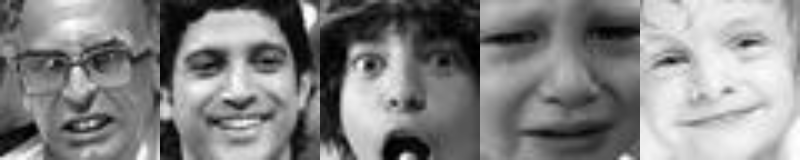

In [ ]:
# get the first batch from the streaming dataset
batch = next(iter(train_dataset))  
images, labels = batch
print(images.shape, labels.shape)

# inspect data type
images = images.numpy()
print(images.dtype, images.min(), images.max())  # float32, [0, 255]

# show some images
sample_labels = labels.numpy()[:5]
sample_images = np.hstack(images[:5])  # stack 5 images horizontally
sample_images = sample_images.astype(np.uint8)  # PIL wants uint8
sample_images = PIL.Image.fromarray(sample_images)  # to PIL image

print(sample_labels)
display(sample_images)  # show it

## **Training**

Since our pretrained network doesn't belong to Keras, we are going to load the Inception ResNet v1 as in the following. 

On the top of the pretrained network, we build our densly connected network. We have a *Flatten layer* that reshape the pretrained network's output. Then, we have two *Dense layers*: the first has 128 hidden layers with **ReLu** activation function while the last one has 7 layers (as the output class we have) with **softmax** activation function. Since we don't want to perform fine-tuning, hence we don't want to recompute the weights of the pretrained network, then we set `trainable = False`.

In [ ]:
weights_path = '/content/gdrive/MyDrive/progetto/modello/keras-facenet/weights/facenet_keras_weights.h5'
top_model_weights_path = '/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/facenet_keras.h5'

pretrained_model = load_model(top_model_weights_path)
pretrained_model.load_weights(weights_path)

for layer in pretrained_model.layers:

    layer.trainable = False

model= Sequential()
model.add(L.Input(shape=(160,160,3)))
model.add(pretrained_model)
model.add(L.Flatten())
model.add(L.Dense(128, activation='relu',name = 'classifier_hidden'))
model.add(L.Dense(7,activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
classifier_hidden (Dense)    (None, 128)               16512     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 22,825,559
Trainable params: 17,415
Non-trainable params: 22,808,144
_________________________________________________________________


Since we have many classes and an image belongs only to a specific class, we use the **sparse categorical crossentropy** as loss function. As optimizer, we use **RMSprop** with a very low **learning rate** ($10^{-5}$) and by using 0.6 **momentum**. In this way we do little step but thanks to momentum we can avoid local minima. To avoid the problem of overfitting, we add also the **early stopping** whereby the training will stop when the chosen performance measure stops improving.


In [ ]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5, momentum=0.6),
              metrics=["acc"])

callbacks = [
    # early stopping
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),

    # model checkpoints (save the best model)
    tf.keras.callbacks.ModelCheckpoint(
        monitor='val_acc',
        save_best_only=True,
        mode='max',
        filepath='/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_epochs_2.h5'),
]

history = model.fit(
      train_dataset,
      epochs=50,
      use_multiprocessing=True,
      callbacks=callbacks,
      validation_data=valid_dataset,
      batch_size=BATCH_SIZE)

Epoch 1/50
718/718 [==============================] - 5182s 7s/step - loss: 1.8754 - acc: 0.2257 - val_loss: 1.9765 - val_acc: 0.0906
Epoch 2/50
718/718 [==============================] - 61s 85ms/step - loss: 1.8167 - acc: 0.2455 - val_loss: 1.9316 - val_acc: 0.1089
Epoch 3/50
718/718 [==============================] - 64s 89ms/step - loss: 1.7933 - acc: 0.2522 - val_loss: 1.9050 - val_acc: 0.1284
Epoch 4/50
718/718 [==============================] - 62s 86ms/step - loss: 1.7838 - acc: 0.2614 - val_loss: 1.8770 - val_acc: 0.1500
Epoch 5/50
718/718 [==============================] - 62s 86ms/step - loss: 1.7742 - acc: 0.2635 - val_loss: 1.8611 - val_acc: 0.1650
Epoch 6/50
718/718 [==============================] - 62s 85ms/step - loss: 1.7662 - acc: 0.2741 - val_loss: 1.8511 - val_acc: 0.1735
Epoch 7/50
718/718 [==============================] - 62s 85ms/step - loss: 1.7623 - acc: 0.2772 - val_loss: 1.8434 - val_acc: 0.1806
Epoch 8/50
718/718 [==============================] - 64s 88ms

## **Plot**
Now we plot the results obtained. We can observe a consistent overfitting and a low accuracy in training results (a little less than 30%).

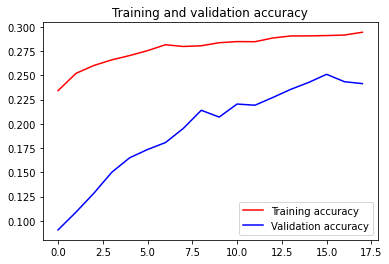

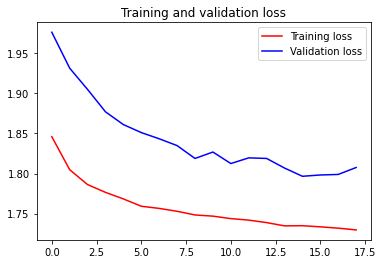

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **Finetune the pretrained network**

We can try to improve these results by performing fine tuning. In particular, in this paper we try to fine tune the last block of the pretrained network by setting `Block8_6_Branch_1_Conv2d_0a_1x1` as trainable `True`. The rest of the network is the same than before.


In [ ]:
pretrained_model.trainable = True


set_trainable = False
for layer in pretrained_model.layers:
    if layer.name == 'Block8_6_Branch_1_Conv2d_0a_1x1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


pretrained_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

Here, we use the same configuration seen before. 

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5, momentum=0.6),
              metrics=['acc'])

In [ ]:
fine_history = model.fit(
      train_dataset,
      epochs=100,
      use_multiprocessing=True,
      callbacks=callbacks,
      validation_data=valid_dataset,
      batch_size=BATCH_SIZE)

Epoch 1/100
718/718 [==============================] - 67s 86ms/step - loss: 1.8253 - acc: 0.2858 - val_loss: 1.6426 - val_acc: 0.3957
Epoch 2/100
718/718 [==============================] - 60s 83ms/step - loss: 1.6570 - acc: 0.3513 - val_loss: 1.5259 - val_acc: 0.4550
Epoch 3/100
718/718 [==============================] - 62s 86ms/step - loss: 1.5830 - acc: 0.3796 - val_loss: 1.4409 - val_acc: 0.4895
Epoch 4/100
718/718 [==============================] - 64s 88ms/step - loss: 1.5204 - acc: 0.4177 - val_loss: 1.3919 - val_acc: 0.5114
Epoch 5/100
718/718 [==============================] - 64s 88ms/step - loss: 1.4824 - acc: 0.4322 - val_loss: 1.3558 - val_acc: 0.5259
Epoch 6/100
718/718 [==============================] - 63s 87ms/step - loss: 1.4408 - acc: 0.4539 - val_loss: 1.3129 - val_acc: 0.5396
Epoch 7/100
718/718 [==============================] - 63s 87ms/step - loss: 1.4069 - acc: 0.4668 - val_loss: 1.2648 - val_acc: 0.5572
Epoch 8/100
718/718 [==============================] - 

## **Plot**
Now, as we can see, we have better performance than before. At the beginning, we have a little *underfitting* but at the end the two curves are very near. Then we have an high accuracy in training (more than 70%) and a little less in testing (equal to 45%).

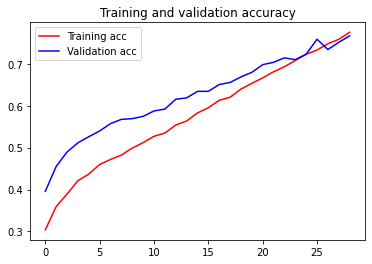

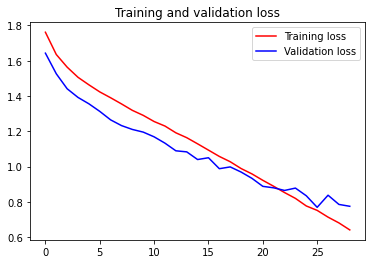

In [ ]:
fine_acc = fine_history.history['acc']
fine_val_acc = fine_history.history['val_acc']
fine_loss = fine_history.history['loss']
fine_val_loss = fine_history.history['val_loss']

epochs = range(len(fine_acc))

plt.plot(epochs, fine_acc, 'r', label='Training acc')
plt.plot(epochs, fine_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, fine_loss, 'r', label='Training loss')
plt.plot(epochs, fine_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




In [ ]:
# evaluate the model on the test set with evaluate() ...
model = tf.keras.models.load_model('/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_epochs_2.h5')
test_loss, test_accuracy = model.evaluate(testing_dataset)
print("Test loss", test_loss)
print("Test accuracy",test_accuracy)

113/113 [==============================] - 989s 9s/step - loss: 1.8398 - acc: 0.4542
Test loss 1.839754343032837
Test accuracy 0.454165518283844


## **Overall plot**
Now we can see the results comparison of both the model performed. Again, we can appreciate the improving of the finetuned model.

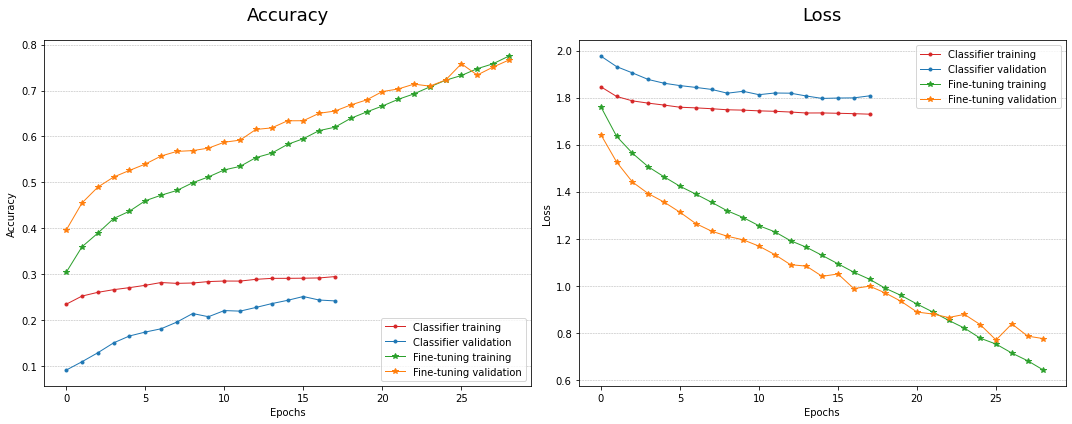

In [ ]:
# data from training with freezed mobilenet
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# data from fine-tuning training
ft_acc = fine_history.history['acc']
ft_val_acc = fine_history.history['val_acc']
ft_loss = fine_history.history['loss']
ft_val_loss = fine_history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))
epochs_1 = range(len(ft_acc))

# plot accuracy curves
acc_g.plot(epochs, acc, color='tab:red', marker='.', linestyle='-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)
acc_g.plot(epochs_1, ft_acc, color='tab:green', marker='*', linestyle='-', label='Fine-tuning training', linewidth=1)
acc_g.plot(epochs_1, ft_val_acc, color='tab:orange', marker='*', linestyle='-', label='Fine-tuning validation', linewidth=1)

# plot loss curves
loss_g.plot(epochs, loss, color='tab:red', marker='.', linestyle='-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)
loss_g.plot(epochs_1, ft_loss, color='tab:green', marker='*', linestyle='-', label='Fine-tuning training ', linewidth=1)
loss_g.plot(epochs_1, ft_val_loss, color='tab:orange', marker='*', linestyle='-', label='Fine-tuning validation', linewidth=1)

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()